# 🧠 Age and Gender Classification Project Documentation
###1.📋 Project Overview
This machine learning SAE project (3rd model) uses a Convolutional Neural Network (CNN) to classify age and gender from facial images using the UTKFace dataset. It demonstrates multi-task learning by simultaneously predicting two distinct attributes (Age and gender) from a single image.
###2.🛠 Prerequisites and Dependencies

Python 3.7+
Libraries:
  -TensorFlow
  -Keras
  -NumPy
  -Pandas
  -Matplotlib
  -Seaborn
  -OpenCV
  -scikit-learn


### Mount Drive and Unzipping UTKFACE dataset

#2.🛠 Prerequisites and Dependencies
Python 3.7+ Libraries: -TensorFlow -Keras -NumPy -Pandas -Matplotlib -Seaborn -OpenCV -scikit-learn

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image

# 3. 🗂 Dataset Preparation



##3.1 Dataset Structure

Dataset: UTKFace



1.   Filename Format: age_gender_race_date.jpg
2.   Key Components:

*   Age: Numerical value
*  Gender: Binary (0: Male, 1: Female)




##3.2 Data Loading Process



*  Mounts Google Drive: connecting google drive to my colab environment to access the files

*   Extracts dataset: unzips the .zip dataset file

*   Shuffles image filenames: by randomly rearranging the order of filenames

*   Extracts age and gender labels: to retreive age and gender info
*   Creates a pandas DataFrame: extract data into a table for analysis




In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/UTKFace.zip

In [ ]:
# Set Base Directory
BASE_DIR = '/content/UTKFace'

In [ ]:
# Data Preparation
age_labels, gender_labels, image_paths = [], [], []
image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

In [ ]:
for image in tqdm(image_filenames):
    image_path = os.path.join(BASE_DIR, image)
    img_components = image.split('_')
    age_label = int(img_components[0])
    gender_label = int(img_components[1])

    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
# Gender Mapping
gender_mapping = {0: 'Male', 1: 'Female'}


##3.3 Age Categorization
Custom function age_bracket() groups ages into these categories:

* 0-9
* 10-19
* 20-29
* 30-39
* 40-49
* 50-59
* 60+

In [ ]:
# Age Bracket Function
def age_bracket(age):
    if age < 10: return "0-9"
    elif age < 20: return "10-19"
    elif age < 30: return "20-29"
    elif age < 40: return "30-39"
    elif age < 50: return "40-49"
    elif age < 60: return "50-59"
    else: return "60+"

In [ ]:
# Convert Data to DataFrame
df = pd.DataFrame({'image_path': image_paths, 'age': age_labels, 'gender': gender_labels})
df['age_bracket'] = df['age'].apply(age_bracket)


#4. 📊 Data Visualization
Two primary visualizations are generated:

Age Distribution Histogram

* Shows frequency of ages in the dataset
* Helps understand age spread


Gender Distribution Bar Plot

* Displays count of male and female images
* Identifies potential class imbalance ( more males than females in this case )

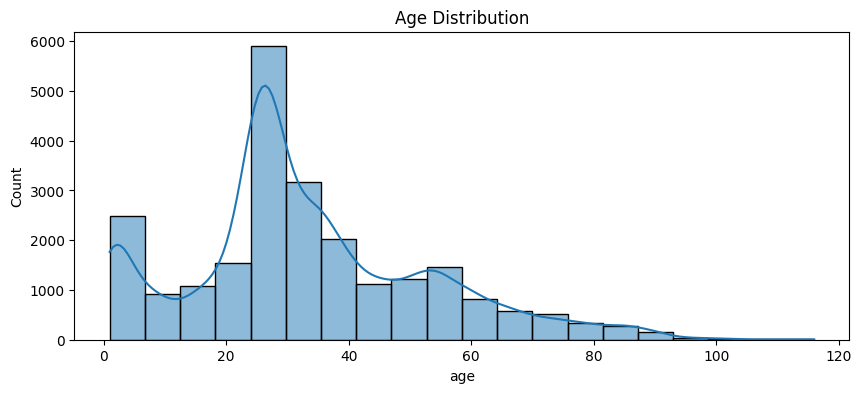

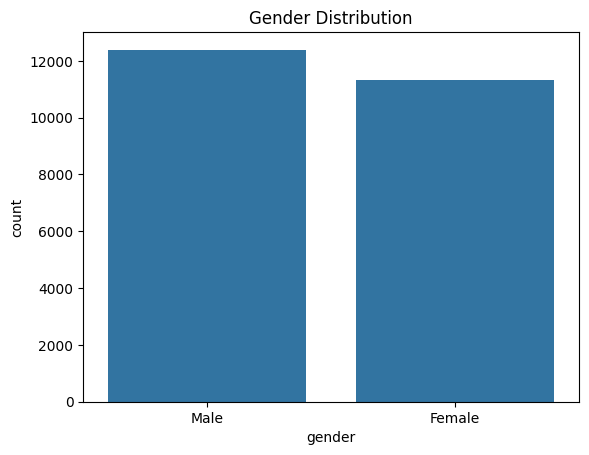

In [ ]:
# Visualize Data Distribution
plt.figure(figsize=(10, 4))
sns.histplot(df['age'], kde=True, bins=20)
plt.title("Age Distribution")
plt.show()

sns.countplot(x=df['gender'].map(gender_mapping))
plt.title("Gender Distribution")
plt.show()

##5. 🖼 Image Preprocessing
5.1 Preprocessing Steps

* Read image using OpenCV library
* Convert color space from BGR to RGB
* Resize to 64x64 pixels
* Normalize pixel values (0-1 range)

In [ ]:
# Image Preprocessing
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    return img

In [ ]:
X = np.array([preprocess_image(path) for path in tqdm(df['image_path'])])
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])


  0%|          | 0/23708 [00:00<?, ?it/s]

###5.2 Data Splitting

* 80% Training
* 20% Testing
* Split using random_state for reproducibility and consistency

In [ ]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(
    X, y_gender, y_age, test_size=0.2, random_state=42)

##6. 🤖 Model Architecture
###6.1 Convolutional Layers

3 Convolutional Layers

* 1st Layer: 32 filters
* 2nd Layer: 64 filters
* 3rd Layer: 128 filters


Max Pooling after each convolution

ReLU activation

###6.2 Fully Connected Layers

* 256 neurons with dropout (0.3)
* 128 neurons with dropout (0.3)

###6.3 Output Layers

* Gender Output: Sigmoid activation (binary classification)
* Age Output: Linear activation (regression)

In [ ]:
# Define Custom CNN Model
inputs = Input(shape=(64, 64, 3))

x = Conv2D(32, (3,3), activation='relu')(inputs)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Output Layers
gender_output = Dense(1, activation='sigmoid', name='gender_out')(x)
age_output = Dense(1, activation='linear', name='age_out')(x)

model = Model(inputs=inputs, outputs=[gender_output, age_output])
model.compile(
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
    optimizer=Adam(learning_rate=0.0001),
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)


##7. 🔍 Model Training
###7.1 Compilation Parameters

Loss Functions:

* Gender: Binary Crossentropy
* Age: Mean Absolute Error


Optimizer: Adam (learning_rate=0.0001)

Metrics: Accuracy for gender, MAE for age

###7.2 Training Callbacks

Early Stopping

* Monitors validation loss
* Patience: 5 epochs


Model Checkpoint

* Saves best model



###7.3 Training Configuration

* Epochs: 30 (Not optimal but I did it to avoid running out of resources on Google Colab)

* Batch Size: 32

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

# =========================
# 9. TRAIN THE MODEL
# =========================
history = model.fit(
    X_train, {'gender_out': y_gender_train, 'age_out': y_age_train},
    validation_data=(X_test, {'gender_out': y_gender_test, 'age_out': y_age_test}),
    epochs=30, batch_size=32, callbacks=callbacks
)


Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - age_out_loss: 19.2812 - age_out_mae: 19.2812 - gender_out_accuracy: 0.5148 - gender_out_loss: 1.2427 - loss: 20.5240

593/593 ━━━━━━━━━━━━━━━━━━━━ 138s 226ms/step - age_out_loss: 19.2771 - age_out_mae: 19.2771 - gender_out_accuracy: 0.5148 - gender_out_loss: 1.2426 - loss: 20.5197 - val_age_out_loss: 14.4636 - val_age_out_mae: 14.4125 - val_gender_out_accuracy: 0.7069 - val_gender_out_loss: 0.6140 - val_loss: 15.0263
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - age_out_loss: 14.3261 - age_out_mae: 14.3261 - gender_out_accuracy: 0.5736 - gender_out_loss: 0.9095 - loss: 15.2356

593/593 ━━━━━━━━━━━━━━━━━━━━ 135s 228ms/step - age_out_loss: 14.3253 - age_out_mae: 14.3253 - gender_out_accuracy: 0.5737 - gender_out_loss: 0.9094 - loss: 15.2347 - val_age_out_loss: 11.8915 - val_age_out_mae: 11.8593 - val_gender_out_accuracy: 0.7400 - val_gender_out_loss: 0.5413 - val_loss: 12.4005
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - age_out_loss: 12.3574 - age_out_mae: 12.3574 - gender_out_accuracy: 0.6619 - gender_out_loss: 0.7359 - loss: 13.0933

593/593 ━━━━━━━━━━━━━━━━━━━━ 141s 227ms/step - age_out_loss: 12.3568 - age_out_mae: 12.3568 - gender_out_accuracy: 0.6619 - gender_out_loss: 0.7358 - loss: 13.0926 - val_age_out_loss: 10.8162 - val_age_out_mae: 10.7759 - val_gender_out_accuracy: 0.7476 - val_gender_out_loss: 0.5217 - val_loss: 11.2976
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - age_out_loss: 11.4460 - age_out_mae: 11.4460 - gender_out_accuracy: 0.6886 - gender_out_loss: 0.6703 - loss: 12.1163

593/593 ━━━━━━━━━━━━━━━━━━━━ 141s 225ms/step - age_out_loss: 11.4457 - age_out_mae: 11.4457 - gender_out_accuracy: 0.6886 - gender_out_loss: 0.6702 - loss: 12.1160 - val_age_out_loss: 10.2718 - val_age_out_mae: 10.2268 - val_gender_out_accuracy: 0.7524 - val_gender_out_loss: 0.5126 - val_loss: 10.7395
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - age_out_loss: 10.8464 - age_out_mae: 10.8464 - gender_out_accuracy: 0.7027 - gender_out_loss: 0.6252 - loss: 11.4716

593/593 ━━━━━━━━━━━━━━━━━━━━ 140s 222ms/step - age_out_loss: 10.8462 - age_out_mae: 10.8462 - gender_out_accuracy: 0.7027 - gender_out_loss: 0.6251 - loss: 11.4714 - val_age_out_loss: 9.8151 - val_age_out_mae: 9.7807 - val_gender_out_accuracy: 0.7619 - val_gender_out_loss: 0.4988 - val_loss: 10.2793
Epoch 6/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - age_out_loss: 10.5971 - age_out_mae: 10.5971 - gender_out_accuracy: 0.7097 - gender_out_loss: 0.6083 - loss: 11.2054

593/593 ━━━━━━━━━━━━━━━━━━━━ 148s 233ms/step - age_out_loss: 10.5969 - age_out_mae: 10.5968 - gender_out_accuracy: 0.7097 - gender_out_loss: 0.6083 - loss: 11.2051 - val_age_out_loss: 9.5573 - val_age_out_mae: 9.5157 - val_gender_out_accuracy: 0.7706 - val_gender_out_loss: 0.4843 - val_loss: 9.9999
Epoch 7/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - age_out_loss: 10.0711 - age_out_mae: 10.0711 - gender_out_accuracy: 0.7193 - gender_out_loss: 0.6016 - loss: 10.6727

593/593 ━━━━━━━━━━━━━━━━━━━━ 140s 229ms/step - age_out_loss: 10.0709 - age_out_mae: 10.0709 - gender_out_accuracy: 0.7193 - gender_out_loss: 0.6016 - loss: 10.6725 - val_age_out_loss: 9.1692 - val_age_out_mae: 9.1170 - val_gender_out_accuracy: 0.7782 - val_gender_out_loss: 0.4752 - val_loss: 9.5920
Epoch 8/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - age_out_loss: 9.5493 - age_out_mae: 9.5493 - gender_out_accuracy: 0.7369 - gender_out_loss: 0.5543 - loss: 10.1035

593/593 ━━━━━━━━━━━━━━━━━━━━ 140s 225ms/step - age_out_loss: 9.5494 - age_out_mae: 9.5494 - gender_out_accuracy: 0.7369 - gender_out_loss: 0.5543 - loss: 10.1036 - val_age_out_loss: 9.0373 - val_age_out_mae: 8.9916 - val_gender_out_accuracy: 0.7876 - val_gender_out_loss: 0.4576 - val_loss: 9.4492
Epoch 9/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 142s 225ms/step - age_out_loss: 9.4852 - age_out_mae: 9.4851 - gender_out_accuracy: 0.7420 - gender_out_loss: 0.5408 - loss: 10.0259 - val_age_out_loss: 9.7313 - val_age_out_mae: 9.6646 - val_gender_out_accuracy: 0.7919 - val_gender_out_loss: 0.4456 - val_loss: 10.1102
Epoch 10/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - age_out_loss: 9.2414 - age_out_mae: 9.2414 - gender_out_accuracy: 0.7556 - gender_out_loss: 0.5180 - loss: 9.7594

593/593 ━━━━━━━━━━━━━━━━━━━━ 145s 231ms/step - age_out_loss: 9.2413 - age_out_mae: 9.2413 - gender_out_accuracy: 0.7556 - gender_out_loss: 0.5180 - loss: 9.7593 - val_age_out_loss: 8.7128 - val_age_out_mae: 8.6764 - val_gender_out_accuracy: 0.8028 - val_gender_out_loss: 0.4259 - val_loss: 9.1024
Epoch 11/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 133s 224ms/step - age_out_loss: 9.0805 - age_out_mae: 9.0805 - gender_out_accuracy: 0.7656 - gender_out_loss: 0.5084 - loss: 9.5890 - val_age_out_loss: 8.9125 - val_age_out_mae: 8.8774 - val_gender_out_accuracy: 0.8180 - val_gender_out_loss: 0.4131 - val_loss: 9.2909
Epoch 12/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - age_out_loss: 8.8551 - age_out_mae: 8.8551 - gender_out_accuracy: 0.7714 - gender_out_loss: 0.4877 - loss: 9.3427

593/593 ━━━━━━━━━━━━━━━━━━━━ 145s 231ms/step - age_out_loss: 8.8548 - age_out_mae: 8.8548 - gender_out_accuracy: 0.7714 - gender_out_loss: 0.4876 - loss: 9.3425 - val_age_out_loss: 7.8749 - val_age_out_mae: 7.8370 - val_gender_out_accuracy: 0.8174 - val_gender_out_loss: 0.4021 - val_loss: 8.2394
Epoch 13/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 142s 230ms/step - age_out_loss: 8.6807 - age_out_mae: 8.6807 - gender_out_accuracy: 0.7872 - gender_out_loss: 0.4635 - loss: 9.1442 - val_age_out_loss: 7.9286 - val_age_out_mae: 7.8947 - val_gender_out_accuracy: 0.8229 - val_gender_out_loss: 0.3894 - val_loss: 8.2847
Epoch 14/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 143s 232ms/step - age_out_loss: 8.4516 - age_out_mae: 8.4516 - gender_out_accuracy: 0.7868 - gender_out_loss: 0.4542 - loss: 8.9058 - val_age_out_loss: 8.4736 - val_age_out_mae: 8.4492 - val_gender_out_accuracy: 0.8311 - val_gender_out_loss: 0.3723 - val_loss: 8.8220
Epoch 15/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - age_out_loss: 8.3359 - age_o

593/593 ━━━━━━━━━━━━━━━━━━━━ 137s 224ms/step - age_out_loss: 8.3358 - age_out_mae: 8.3358 - gender_out_accuracy: 0.8072 - gender_out_loss: 0.4321 - loss: 8.7679 - val_age_out_loss: 7.8748 - val_age_out_mae: 7.8445 - val_gender_out_accuracy: 0.8364 - val_gender_out_loss: 0.3654 - val_loss: 8.2106
Epoch 16/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - age_out_loss: 8.0410 - age_out_mae: 8.0410 - gender_out_accuracy: 0.8108 - gender_out_loss: 0.4218 - loss: 8.4628

593/593 ━━━━━━━━━━━━━━━━━━━━ 147s 233ms/step - age_out_loss: 8.0410 - age_out_mae: 8.0410 - gender_out_accuracy: 0.8108 - gender_out_loss: 0.4218 - loss: 8.4628 - val_age_out_loss: 7.9000 - val_age_out_mae: 7.8609 - val_gender_out_accuracy: 0.8393 - val_gender_out_loss: 0.3486 - val_loss: 8.2100
Epoch 17/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - age_out_loss: 7.9935 - age_out_mae: 7.9935 - gender_out_accuracy: 0.8151 - gender_out_loss: 0.4067 - loss: 8.4002

593/593 ━━━━━━━━━━━━━━━━━━━━ 137s 225ms/step - age_out_loss: 7.9935 - age_out_mae: 7.9935 - gender_out_accuracy: 0.8151 - gender_out_loss: 0.4067 - loss: 8.4002 - val_age_out_loss: 7.2973 - val_age_out_mae: 7.2601 - val_gender_out_accuracy: 0.8480 - val_gender_out_loss: 0.3451 - val_loss: 7.6058
Epoch 18/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - age_out_loss: 7.8070 - age_out_mae: 7.8070 - gender_out_accuracy: 0.8183 - gender_out_loss: 0.3971 - loss: 8.2042

593/593 ━━━━━━━━━━━━━━━━━━━━ 143s 226ms/step - age_out_loss: 7.8071 - age_out_mae: 7.8071 - gender_out_accuracy: 0.8183 - gender_out_loss: 0.3971 - loss: 8.2043 - val_age_out_loss: 7.2863 - val_age_out_mae: 7.2583 - val_gender_out_accuracy: 0.8528 - val_gender_out_loss: 0.3303 - val_loss: 7.5894
Epoch 19/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - age_out_loss: 7.6117 - age_out_mae: 7.6117 - gender_out_accuracy: 0.8254 - gender_out_loss: 0.3907 - loss: 8.0023

593/593 ━━━━━━━━━━━━━━━━━━━━ 141s 225ms/step - age_out_loss: 7.6118 - age_out_mae: 7.6118 - gender_out_accuracy: 0.8254 - gender_out_loss: 0.3907 - loss: 8.0025 - val_age_out_loss: 7.2781 - val_age_out_mae: 7.2502 - val_gender_out_accuracy: 0.8511 - val_gender_out_loss: 0.3280 - val_loss: 7.5791
Epoch 20/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - age_out_loss: 7.6609 - age_out_mae: 7.6609 - gender_out_accuracy: 0.8194 - gender_out_loss: 0.3939 - loss: 8.0548

593/593 ━━━━━━━━━━━━━━━━━━━━ 142s 225ms/step - age_out_loss: 7.6609 - age_out_mae: 7.6609 - gender_out_accuracy: 0.8194 - gender_out_loss: 0.3939 - loss: 8.0548 - val_age_out_loss: 7.0797 - val_age_out_mae: 7.0526 - val_gender_out_accuracy: 0.8551 - val_gender_out_loss: 0.3233 - val_loss: 7.3766
Epoch 21/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - age_out_loss: 7.5253 - age_out_mae: 7.5253 - gender_out_accuracy: 0.8287 - gender_out_loss: 0.3760 - loss: 7.9013

593/593 ━━━━━━━━━━━━━━━━━━━━ 142s 225ms/step - age_out_loss: 7.5253 - age_out_mae: 7.5253 - gender_out_accuracy: 0.8287 - gender_out_loss: 0.3760 - loss: 7.9013 - val_age_out_loss: 7.0102 - val_age_out_mae: 6.9796 - val_gender_out_accuracy: 0.8568 - val_gender_out_loss: 0.3222 - val_loss: 7.3025
Epoch 22/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 141s 223ms/step - age_out_loss: 7.4361 - age_out_mae: 7.4361 - gender_out_accuracy: 0.8295 - gender_out_loss: 0.3814 - loss: 7.8174 - val_age_out_loss: 8.0107 - val_age_out_mae: 7.9983 - val_gender_out_accuracy: 0.8629 - val_gender_out_loss: 0.3185 - val_loss: 8.3175
Epoch 23/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - age_out_loss: 7.3800 - age_out_mae: 7.3800 - gender_out_accuracy: 0.8312 - gender_out_loss: 0.3692 - loss: 7.7492

593/593 ━━━━━━━━━━━━━━━━━━━━ 133s 224ms/step - age_out_loss: 7.3800 - age_out_mae: 7.3800 - gender_out_accuracy: 0.8312 - gender_out_loss: 0.3692 - loss: 7.7493 - val_age_out_loss: 7.0024 - val_age_out_mae: 6.9808 - val_gender_out_accuracy: 0.8680 - val_gender_out_loss: 0.3055 - val_loss: 7.2871
Epoch 24/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - age_out_loss: 7.3179 - age_out_mae: 7.3179 - gender_out_accuracy: 0.8396 - gender_out_loss: 0.3605 - loss: 7.6784

593/593 ━━━━━━━━━━━━━━━━━━━━ 131s 221ms/step - age_out_loss: 7.3178 - age_out_mae: 7.3178 - gender_out_accuracy: 0.8396 - gender_out_loss: 0.3605 - loss: 7.6783 - val_age_out_loss: 6.8325 - val_age_out_mae: 6.8156 - val_gender_out_accuracy: 0.8612 - val_gender_out_loss: 0.3119 - val_loss: 7.1283
Epoch 25/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 134s 225ms/step - age_out_loss: 7.1049 - age_out_mae: 7.1049 - gender_out_accuracy: 0.8399 - gender_out_loss: 0.3576 - loss: 7.4625 - val_age_out_loss: 6.9535 - val_age_out_mae: 6.9234 - val_gender_out_accuracy: 0.8699 - val_gender_out_loss: 0.2957 - val_loss: 7.2200
Epoch 26/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - age_out_loss: 7.1314 - age_out_mae: 7.1314 - gender_out_accuracy: 0.8414 - gender_out_loss: 0.3471 - loss: 7.4786

593/593 ━━━━━━━━━━━━━━━━━━━━ 143s 228ms/step - age_out_loss: 7.1314 - age_out_mae: 7.1314 - gender_out_accuracy: 0.8414 - gender_out_loss: 0.3471 - loss: 7.4785 - val_age_out_loss: 6.7752 - val_age_out_mae: 6.7590 - val_gender_out_accuracy: 0.8733 - val_gender_out_loss: 0.2917 - val_loss: 7.0517
Epoch 27/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - age_out_loss: 7.0496 - age_out_mae: 7.0496 - gender_out_accuracy: 0.8434 - gender_out_loss: 0.3539 - loss: 7.4034

593/593 ━━━━━━━━━━━━━━━━━━━━ 141s 225ms/step - age_out_loss: 7.0496 - age_out_mae: 7.0496 - gender_out_accuracy: 0.8434 - gender_out_loss: 0.3538 - loss: 7.4034 - val_age_out_loss: 6.7620 - val_age_out_mae: 6.7477 - val_gender_out_accuracy: 0.8760 - val_gender_out_loss: 0.2908 - val_loss: 7.0394
Epoch 28/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 141s 224ms/step - age_out_loss: 6.9298 - age_out_mae: 6.9298 - gender_out_accuracy: 0.8465 - gender_out_loss: 0.3486 - loss: 7.2784 - val_age_out_loss: 7.1633 - val_age_out_mae: 7.1412 - val_gender_out_accuracy: 0.8768 - val_gender_out_loss: 0.2893 - val_loss: 7.4313
Epoch 29/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 136s 230ms/step - age_out_loss: 6.8330 - age_out_mae: 6.8330 - gender_out_accuracy: 0.8469 - gender_out_loss: 0.3392 - loss: 7.1722 - val_age_out_loss: 6.7898 - val_age_out_mae: 6.7688 - val_gender_out_accuracy: 0.8792 - val_gender_out_loss: 0.2892 - val_loss: 7.0589
Epoch 30/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - age_out_loss: 6.8848 - age_o

593/593 ━━━━━━━━━━━━━━━━━━━━ 137s 221ms/step - age_out_loss: 6.8847 - age_out_mae: 6.8847 - gender_out_accuracy: 0.8544 - gender_out_loss: 0.3348 - loss: 7.2195 - val_age_out_loss: 6.6842 - val_age_out_mae: 6.6617 - val_gender_out_accuracy: 0.8610 - val_gender_out_loss: 0.3101 - val_loss: 6.9726


In [ ]:

# Save Model
model.save("gender_age_model.h5")

##8. 📈 Performance Evaluation
Visualization of training metrics:

* Gender Classification Accuracy

* Overall Loss

* Age Regression Mean Absolute Error

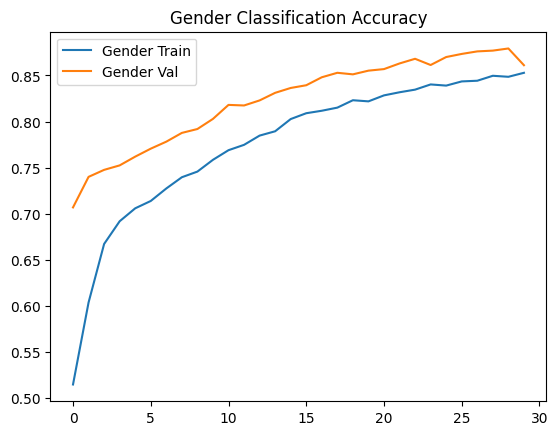

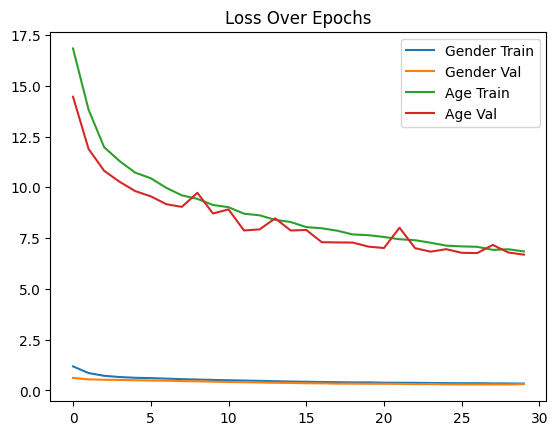

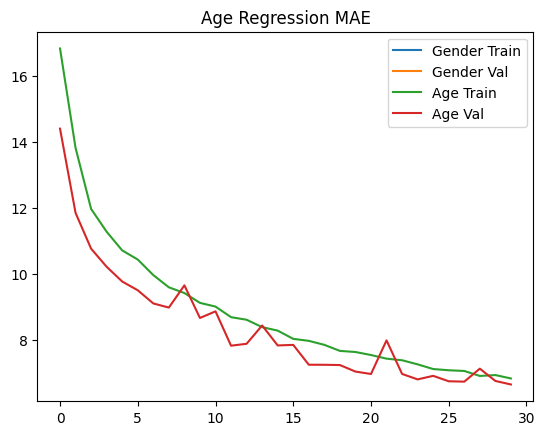

In [ ]:
def plot_performance(history, metric, title):
    plt.plot(history.history.get(f'gender_out_{metric}', []), label='Gender Train')
    plt.plot(history.history.get(f'val_gender_out_{metric}', []), label='Gender Val')
    if metric != 'accuracy':  # Avoid plotting accuracy for age regression
        plt.plot(history.history.get(f'age_out_{metric}', []), label='Age Train')
        plt.plot(history.history.get(f'val_age_out_{metric}', []), label='Age Val')
    plt.title(title)
    plt.legend()
    plt.show()

plot_performance(history, 'accuracy', 'Gender Classification Accuracy')
plot_performance(history, 'loss', 'Loss Over Epochs')
plot_performance(history, 'mae', 'Age Regression MAE')

##9. 🔮 Prediction Function

* Preprocesses a single image
* Predicts gender and age
* Displays image with predictions

In [ ]:
# Prediction Function
def predict_image(image_path):
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    gender_pred, age_pred = model.predict(img)
    gender = gender_mapping[int(gender_pred[0][0] > 0.5)]
    age = round(age_pred[0][0])
    plt.imshow(cv2.imread(image_path)[..., ::-1])
    plt.title(f'Predicted Gender: {gender}, Age: {age}')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


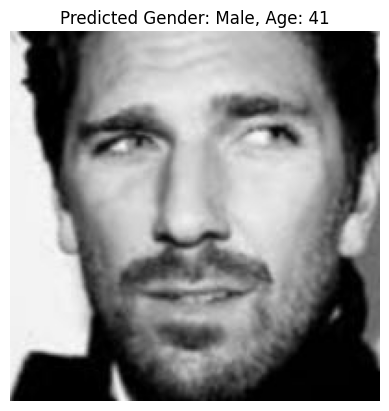

In [ ]:
# Test Prediction
sample_image = df['image_path'].iloc[15]
predict_image(sample_image)